In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.NSGA2 import nsga2
from algorithms.NSGA2.evolutionary_operators import *

from algorithms.MOEAD import moead
from algorithms.MOEAD.evolutionary_operators import *

from algorithms.risk_measures import *

from data import load_stock_quotations

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

# Load data

In [2]:
stock_quotations = load_stock_quotations()

delta_t = 90
stock_returns = stock_quotations.xs('close', level=1, axis=1).pct_change()
last_returns = stock_returns[-delta_t-1:-1]

stock_returns_mean = last_returns.mean() # predicted return for next day

# variance as risk
stock_returns_var = last_returns.var() # risk
stock_returns_cov = last_returns.cov() # covariance matrix

# semi-variance as risk
stock_returns_semi_var = semi_variance(last_returns)
stock_returns_semi_cov = semi_covariance_matrix(np.array(last_returns))

number_of_stocks = stock_returns.shape[1]

# Objective function

In [3]:
def portfolio_return_value(X):
    return X @ stock_returns_mean


def portfolio_risk_var(X):
    return np.diag(X @ stock_returns_cov @ X.T)


def portfolio_risk_semi_var(X):
    return np.diag(X @ stock_returns_semi_cov @ X.T)


def portfolio_objective_function(risk_function=portfolio_risk_semi_var,
                                 return_function=portfolio_return_value):
    return lambda X: np.c_[risk_function(X), -return_function(X)]

# Test

In [4]:
def show_results(moead_result, nsga2_result, stock_risk, objective_function):
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.scatter(stock_risk, stock_returns_mean, c='black')

    pareto_front_moead = objective_function(moead_result)
    pareto_front_nsga2 = objective_function(nsga2_result)

    plt.scatter(pareto_front_moead[:,0], -pareto_front_moead[:,1], c='r')
    plt.scatter(pareto_front_nsga2[:,0], -pareto_front_nsga2[:,1], c='b')

    plt.legend(['Basic stocks', 'MOEA/D', 'NSGA-II'])
    plt.show()

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


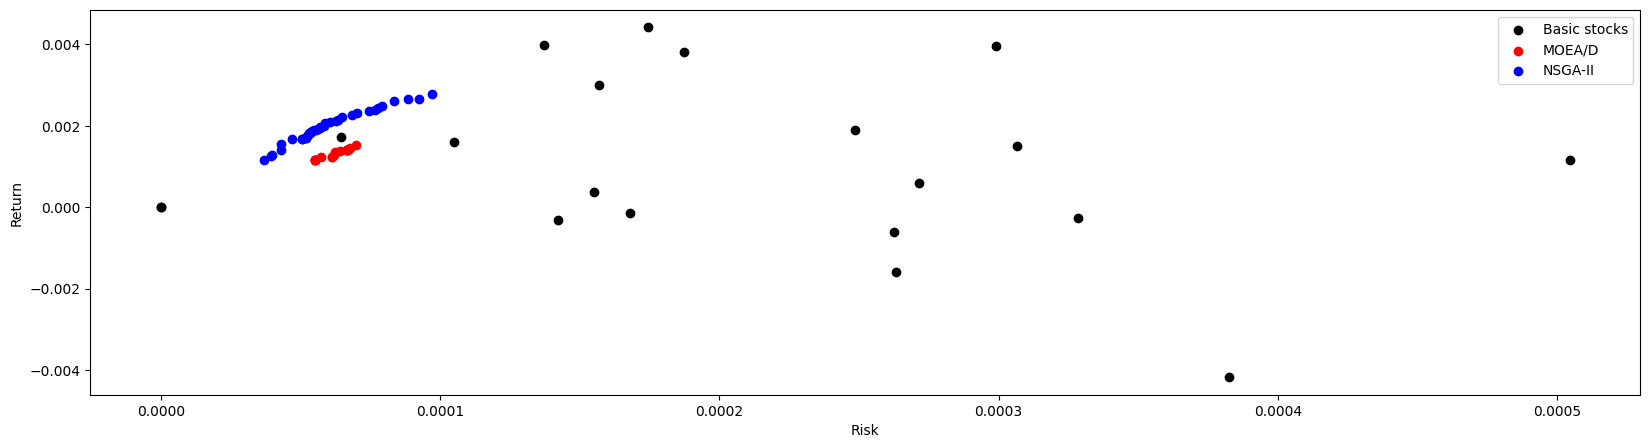

In [5]:
objctive_function = portfolio_objective_function(risk_function=portfolio_risk_semi_var)

moead_result = moead(objective_function=objctive_function,
                     chromosome_length=number_of_stocks,
                     number_of_iterations=10)

nsga2_result = nsga2(objective_function=objctive_function,
                     chromosome_length=number_of_stocks,
                     number_of_iterations=10)

show_results(moead_result=moead_result,
             nsga2_result=nsga2_result,
             stock_risk=stock_returns_semi_var,
             objective_function=objctive_function)

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


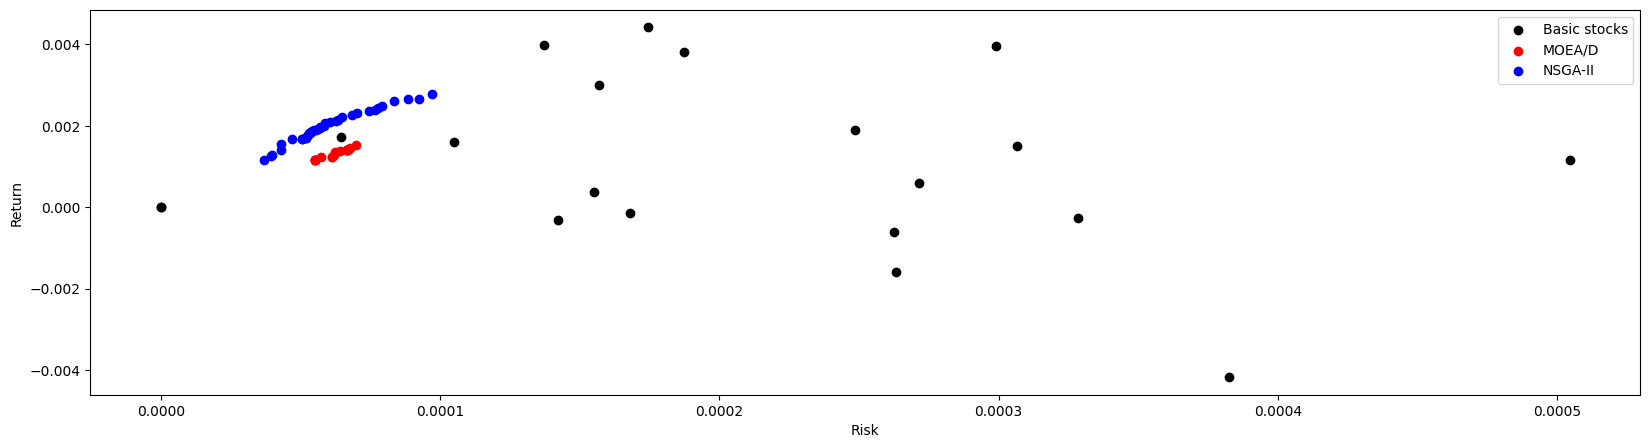

In [6]:
objctive_function = portfolio_objective_function(risk_function=portfolio_risk_semi_var)

moead_result = moead(objective_function=objctive_function,
                     chromosome_length=number_of_stocks,
                     number_of_iterations=10)

nsga2_result = nsga2(objective_function=objctive_function,
                     chromosome_length=number_of_stocks,
                     number_of_iterations=10)

show_results(moead_result=moead_result,
             nsga2_result=nsga2_result,
             stock_risk=stock_returns_semi_var,
             objective_function=objctive_function)